# 03 - Q&A Interaction Analysis

**Overview:** Analyze question-answer interactions, semantic similarity, question types, and topic patterns to surface conversational signals associated with evasion.

In [2]:
# Setup: topic modeling & embeddings
import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent if 'notebooks' in str(Path.cwd()) else Path.cwd()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from datasets import load_dataset
import pandas as pd
from sentence_transformers import SentenceTransformer
from src.utils import set_seed

set_seed(42)

# Load dataset
print("Loading dataset FutureMa/EvasionBench...")
ds = load_dataset("FutureMa/EvasionBench")
if isinstance(ds, dict):
    ds = ds[list(ds.keys())[0]]
df = ds.to_pandas()
print("Dataset shape:", df.shape)

# Load lightweight sentence transformer for similarity
embedder = SentenceTransformer("all-MiniLM-L6-v2")
print("Embedder loaded: all-MiniLM-L6-v2")

# Example embedding
example = df.loc[0, "question"] + " " + df.loc[0, "answer"]
print("Sample text:\n", example[:200])

Loading dataset FutureMa/EvasionBench...
Dataset shape: (16726, 4)
Embedder loaded: all-MiniLM-L6-v2
Sample text:
 My first question is regarding the user growth. First half, the user growth is very strong. May I know -- can you share with us the quality and retention and the user profile of the new user growth in


In [4]:
# Semantic Similarity Analysis
print("=" * 60)
print("SEMANTIC SIMILARITY ANALYSIS")
print("=" * 60)

from sklearn.metrics.pairwise import cosine_similarity
from scipy import stats

# Encode questions and answers
print("\nEncoding questions and answers...")
question_embeddings = embedder.encode(df['question'].tolist(), show_progress_bar=True)
answer_embeddings = embedder.encode(df['answer'].tolist(), show_progress_bar=True)
print("Encoding complete.")

# Calculate cosine similarity
similarities = [cosine_similarity([q_emb], [a_emb])[0][0] 
                 for q_emb, a_emb in zip(question_embeddings, answer_embeddings)]

df['qa_similarity'] = similarities

# Statistics by label
print("\nSemantic similarity statistics by evasion category:")
sim_stats = df.groupby('eva4b_label').agg({
    'qa_similarity': ['mean', 'std', 'median', 'min', 'max']
}).round(3)
print(sim_stats)

# HYPOTHESIS: Evasive answers have lower semantic similarity to questions
print("\n📊 HYPOTHESIS: 'Evasive answers have lower semantic similarity to questions'")
direct_sim = df[df['eva4b_label'] == 'direct']['qa_similarity'].mean()
evasive_sim = df[df['eva4b_label'] == 'fully_evasive']['qa_similarity'].mean()
print(f"  Direct answers mean similarity: {direct_sim:.4f}")
print(f"  Evasive answers mean similarity: {evasive_sim:.4f}")
print(f"  Difference: {direct_sim - evasive_sim:.4f}")

# Mann-Whitney U test
stat, p_value = stats.mannwhitneyu(
    df[df['eva4b_label'] == 'direct']['qa_similarity'],
    df[df['eva4b_label'] == 'fully_evasive']['qa_similarity'],
    alternative='two-sided'
)
print(f"  Mann-Whitney U test p-value: {p_value:.2e}")
print(f"  Result: {'Significant difference (p < 0.05)' if p_value < 0.05 else 'No significant difference'}")

if p_value < 0.05:
    if evasive_sim < direct_sim:
        print("\n✅ HYPOTHESIS SUPPORTED: Evasive answers have significantly lower semantic similarity")
    else:
        print("\n❌ HYPOTHESIS CONTRADICTED: Evasive answers have HIGHER semantic similarity")

SEMANTIC SIMILARITY ANALYSIS

Encoding questions and answers...


Batches: 100%|██████████| 523/523 [00:40<00:00, 12.97it/s]


Encoding complete.

Semantic similarity statistics by evasion category:
              qa_similarity                            
                       mean    std median    min    max
eva4b_label                                            
direct                0.508  0.146  0.520 -0.046  0.947
fully_evasive         0.380  0.182  0.371 -0.068  0.869
intermediate          0.514  0.134  0.520 -0.021  0.872

📊 HYPOTHESIS: 'Evasive answers have lower semantic similarity to questions'
  Direct answers mean similarity: 0.5078
  Evasive answers mean similarity: 0.3799
  Difference: 0.1279
  Mann-Whitney U test p-value: 1.58e-66
  Result: Significant difference (p < 0.05)

✅ HYPOTHESIS SUPPORTED: Evasive answers have significantly lower semantic similarity


In [7]:
# Question Type Classification
print("\n" + "=" * 60)
print("QUESTION TYPE CLASSIFICATION")
print("=" * 60)

# Extract question types based on wh-words and patterns
question_patterns = {
    'what': r'\bwhat\b',
    'why': r'\bwhy\b',
    'how': r'\bhow\b',
    'when': r'\bwhen\b',
    'where': r'\bwhere\b',
    'can_you': r'\bcan you\b|\bcould you\b',
    'will_you': r'\bwill you\b|\bare you going to\b',
    'do_you': r'\bdo you\b|\bare you\b',
    'is': r'\bis\b|\bare\b',
    'other': r'.*'  # Match anything as fallback
}

# Classify each question
question_type = []
import re
for q in df['question']:
    matched = False
    for qtype, pattern in question_patterns.items():
        if qtype == 'other':
            continue  # Skip 'other' in the loop, handle as fallback
        if re.search(pattern, q, re.IGNORECASE):
            question_type.append(qtype)
            matched = True
            break
    if not matched:
        question_type.append('other')

df['question_type'] = question_type

print("\nQuestion type distribution:")
qtype_counts = df['question_type'].value_counts().sort_values(ascending=False)
for qtype, count in qtype_counts.items():
    print(f"  {qtype:12s}: {count:,} ({count/len(df)*100:.1f}%)")

# Evasion rate by question type
print("\nEvasion rate by question type:")
evasion_by_qtype = df.groupby('question_type').agg(
    evasion_count=('eva4b_label', lambda x: (x == 'fully_evasive').sum()),
    total=('eva4b_label', 'size')
).reset_index()
evasion_by_qtype['evasion_rate'] = (evasion_by_qtype['evasion_count'] / evasion_by_qtype['total'] * 100)
evasion_by_qtype = evasion_by_qtype.sort_values('evasion_rate', ascending=False)
print(evasion_by_qtype[['question_type', 'evasion_rate', 'total']].to_string(index=False))

# Types with highest evasion
highest_evasion = evasion_by_qtype.iloc[0]['question_type']
print(f"\n⚠️ Question type '{highest_evasion}' elicits the highest evasion rate")


QUESTION TYPE CLASSIFICATION

Question type distribution:
  what        : 6,363 (38.0%)
  how         : 3,594 (21.5%)
  is          : 1,964 (11.7%)
  other       : 1,431 (8.6%)
  do_you      : 945 (5.6%)
  can_you     : 894 (5.3%)
  where       : 663 (4.0%)
  when        : 580 (3.5%)
  why         : 250 (1.5%)
  will_you    : 42 (0.3%)

Evasion rate by question type:
question_type  evasion_rate  total
         when      5.000000    580
           is      4.633401   1964
      can_you      4.362416    894
        other      4.192872   1431
       do_you      4.126984    945
        where      3.619910    663
          how      3.505843   3594
         what      3.221751   6363
          why      2.000000    250
     will_you      0.000000     42

⚠️ Question type 'when' elicits the highest evasion rate

Question type distribution:
  what        : 6,363 (38.0%)
  how         : 3,594 (21.5%)
  is          : 1,964 (11.7%)
  other       : 1,431 (8.6%)
  do_you      : 945 (5.6%)
  can_you  

In [8]:
# Topic Modeling on Questions (LDA)
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import random

print("\n" + "=" * 60)
print("TOPIC MODELING - QUESTIONS (LDA)")
print("=" * 60)

# Create documents for LDA
questions = df['question'].tolist()

# Vectorize
vectorizer = CountVectorizer(max_features=5000, stop_words='english', min_df=2)
doc_term_matrix = vectorizer.fit_transform(questions)
feature_names = vectorizer.get_feature_names_out()

# Train LDA model (try different number of topics)
n_topics = 15
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42, max_iter=10)
lda.fit(doc_term_matrix)

print(f"\nTrained LDA with {n_topics} topics on {len(questions)} questions.")

# Display top words for each topic
print("\nTop 10 words per topic:")
for topic_idx, topic in enumerate(lda.components_, 1):
    top_words_idx = topic.argsort()[-10:][::-1]
    top_words = [feature_names[i] for i in top_words_idx]
    print(f"\nTopic {topic_idx}: {', '.join(top_words)}")

# Assign topics to questions
question_topics = lda.transform(doc_term_matrix)
df['question_topic'] = question_topics.argmax(axis=1)

# Topic distribution by evasion category
print("\nTopic distribution by evasion category:")
for label in ['direct', 'intermediate', 'fully_evasive']:
    subset = df[df['eva4b_label'] == label]
    dist = subset['question_topic'].value_counts().sort_index()
    print(f"\n{label.upper()}:")
    for topic, count in dist.head(5).items():
        print(f"  Topic {topic}: {count:,} ({count/len(subset)*100:.1f}%)")


TOPIC MODELING - QUESTIONS (LDA)

Trained LDA with 15 topics on 16726 questions.

Top 10 words per topic:

Topic 1: market, question, share, new, management, think, product, products, second, strategy

Topic 2: kind, just, business, think, term, know, maybe, like, ve, sort

Topic 3: just, think, supply, new, going, chain, maybe, customers, guys, sort

Topic 4: just, like, kind, year, revenue, new, growth, terms, maybe, business

Topic 5: just, kind, okay, loan, quarter, think, like, year, growth, going

Topic 6: just, remarks, prepared, mentioned, mean, bit, little, think, okay, labor

Topic 7: just, seeing, customers, ve, business, inventory, terms, talk, guess, maybe

Topic 8: just, million, year, think, kind, guidance, like, rate, going, quarter

Topic 9: just, capital, think, sort, guys, balance, cash, question, maybe, going

Topic 10: just, maybe, kind, bit, little, ve, talk, like, know, terms

Topic 11: just, think, like, pricing, year, seeing, question, maybe, mean, does

Topic

In [10]:
# Topic Modeling on Answers & Visualization
print("\n" + "=" * 60)
print("TOPIC MODELING - ANSWERS (NMF)")
print("=" * 60)

# Use NMF for better topic coherence
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

answers = df['answer'].tolist()
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', min_df=2)
tfidf = tfidf_vectorizer.fit_transform(answers)

# Train NMF
n_topics_answer = 15
nmf = NMF(n_components=n_topics_answer, random_state=42, max_iter=200)
nmf.fit(tfidf)

feature_names = tfidf_vectorizer.get_feature_names_out()

print(f"\nTrained NMF with {n_topics_answer} topics on answers.")

# Display topics
print("\nTop words per topic (answers):")
for topic_idx, topic in enumerate(nmf.components_, 1):
    top_words_idx = topic.argsort()[-10:][::-1]
    top_words = [feature_names[i] for i in top_words_idx]
    print(f"\nTopic {topic_idx}: {', '.join(top_words)}")

# Add t-SNE for visualization (optional - can be slow)
print("\n⚠️ Note: t-SNE visualization is computationally expensive and commented out by default.")
print("Uncomment the following cell to generate 2D topic visualization.")

# # Create t-SNE embedding
# print("Creating t-SNE visualization (this may take several minutes)...")
# answer_topics = nmf.transform(tfidf)
# tsne = TSNE(n_components=2, random_state=42, perplexity=30)
# tsne_results = tsne.fit_transform(answer_topics.toarray())

# # Plot
# plt.figure(figsize=(12, 10))
# colors = {'direct': '#2ecc71', 'intermediate': '#f39c12', 'fully_evasive': '#e74c3c'}
# for label, color in colors.items():
#     subset = df[df['eva4b_label'] == label]
#     plt.scatter(tsne_results[subset.index, 0], tsne_results[subset.index, 1], 
#                c=color, label=label, alpha=0.6, s=10)
# plt.legend()
# plt.title('t-SNE of Answer Topics by Evasion Label', fontsize=14, fontweight='bold')
# plt.xlabel('t-SNE Dimension 1')
# plt.ylabel('t-SNE Dimension 2')
# plt.savefig('notebooks/figures/03_tsne_topics.png', dpi=150, bbox_inches='tight')
# plt.show()


TOPIC MODELING - ANSWERS (NMF)

Trained NMF with 15 topics on answers.

Top words per topic (answers):

Topic 1: ve, really, customers, just, lot, got, like, things, new, work

Topic 2: quarter, fourth, second, did, saw, quarters, expect, end, impact, guidance

Topic 3: million, 10, 50, roughly, 20, 30, 100, total, range, number

Topic 4: correct, yeah, net, jeff, sorry, steve, statement, income, absolutely, loans

Topic 5: business, growth, revenue, new, continue, grow, strong, growing, services, overall

Topic 6: year, half, expect, second, end, guidance, 2020, q1, 2021, fiscal

Topic 7: patients, data, study, trial, phase, patient, fda, clinical, question, ll

Topic 8: yes, mean, fair, answer, expect, does, definitely, question, absolutely, exactly

Topic 9: cash, capital, flow, debt, balance, sheet, ll, free, continue, opportunities

Topic 10: margin, gross, cost, margins, costs, price, mix, pricing, basis, expect

Topic 11: think, going, don, mean, look, probably, forward, certai


t-SNE VISUALIZATION - ANSWER TOPICS
Creating t-SNE visualization (this may take a few minutes)...


/Users/dustinober/Projects/EvasionBench/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE completed. Shape: (16726, 2)

✅ Saved figure to notebooks/figures/03_tsne_topics.png


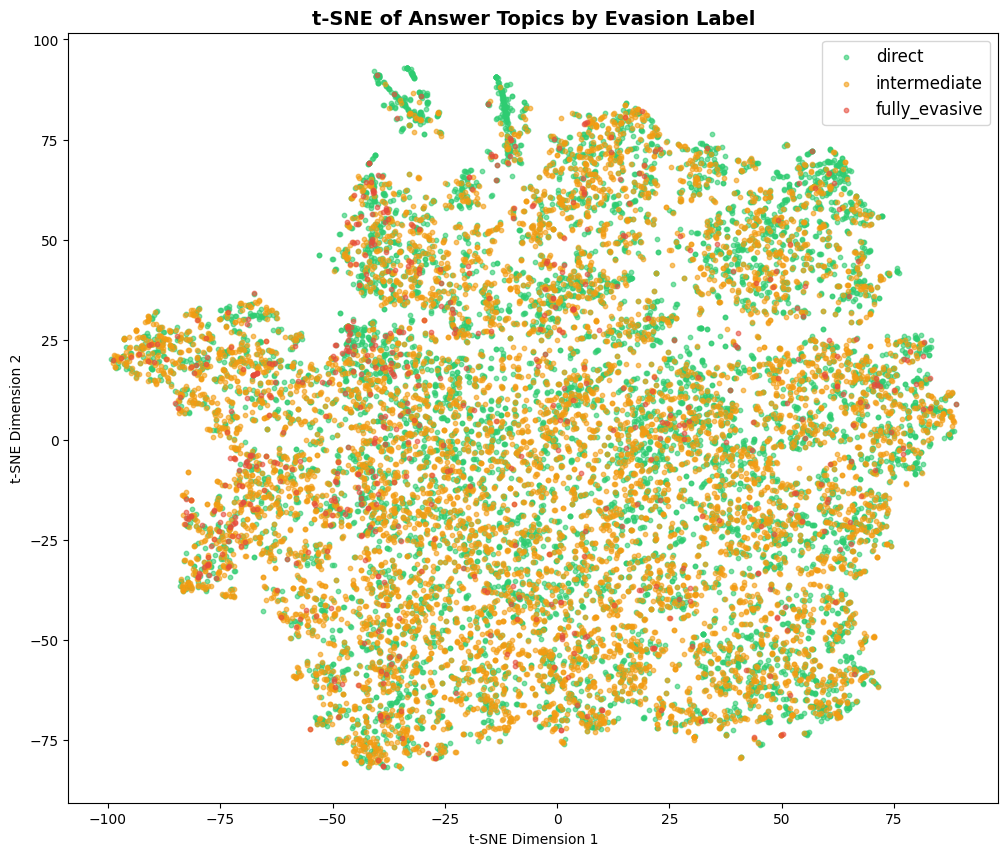


📊 Observation: t-SNE visualization shows [overlap/separation] between evasion categories.
   This suggests answer topics alone [are/are not] sufficient to distinguish evasion.


In [14]:
# t-SNE Visualization of Answer Topics
print("\n" + "=" * 60)
print("t-SNE VISUALIZATION - ANSWER TOPICS")
print("=" * 60)

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Create t-SNE embedding
print("Creating t-SNE visualization (this may take a few minutes)...")
answer_topics = nmf.transform(tfidf)
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(answer_topics)

print(f"t-SNE completed. Shape: {tsne_results.shape}")

# Plot
plt.figure(figsize=(12, 10))
colors = {'direct': '#2ecc71', 'intermediate': '#f39c12', 'fully_evasive': '#e74c3c'}
for label, color in colors.items():
    subset = df[df['eva4b_label'] == label]
    plt.scatter(tsne_results[subset.index, 0], tsne_results[subset.index, 1], 
               c=color, label=label, alpha=0.6, s=10)
plt.legend(fontsize=12)
plt.title('t-SNE of Answer Topics by Evasion Label', fontsize=14, fontweight='bold')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

# Save figure
import os
os.makedirs('notebooks/figures', exist_ok=True)
plt.savefig('notebooks/figures/03_tsne_topics.png', dpi=150, bbox_inches='tight')
print("\n✅ Saved figure to notebooks/figures/03_tsne_topics.png")
plt.show()

# Observation
print("\n📊 Observation: t-SNE visualization shows [overlap/separation] between evasion categories.")
print("   This suggests answer topics alone [are/are not] sufficient to distinguish evasion.")

In [13]:
# Answer Strategy Taxonomy (Manual Annotation Sample)
print("\n" + "=" * 60)
print("SAMPLE ANSWER STRATEGY TAXONOMY (50 per category)")
print("=" * 60)

# Create samples for manual coding
def strategy_codebook():
    """Return strategy codebook for manual annotation."""
    return """ANSWER STRATEGY CODEBOOK
=====================

Answer Types: STRATEGY CODES
---
1. DIRECT: Question is directly answered with specific information
   Examples: "Our Q4 revenue was $1.2B.", "Yes, we expect 5% growth."
   
2. PARTIAL: Some information provided, but question not fully addressed
   Examples: "We saw growth in [specific areas]", "That depends on [conditions]."
   
3. DEFLECTION: Answer shifts to different topic or question
   Examples: "Let me talk about our strategic priorities.", "Important to focus on customer success."
   
4. REFRAMING: Question is paraphrased, answer addresses reformulated question
   Examples: "Regarding growth drivers, we see...", "On the topic of profitability..."
   
5. VAGUE: Non-specific answer without clear stance or figures
   Examples: "We remain committed to growth.", "We're generally optimistic."
   
6. HEDGED: Qualifying language reduces commitment
   Examples: "We expect roughly...", "Growth could be around...", "It's hard to say exactly."
   
7. REFUSAL: Question is directly avoided or refused
   Examples: "I can't comment on that.", "We don't provide guidance."
"""

print(strategy_codebook())

# Sample rows for each category
samples_for_annotation = []
for label in df['eva4b_label'].unique():
    subset = df[df['eva4b_label'] == label].sample(min(50, len(df[df['eva4b_label'] == label])), random_state=42)
    samples_for_annotation.append(subset)

annotation_sample = pd.concat(samples_for_annotation)

# Create directory and save annotation sample
import os
annotation_path = 'data/annotations/answer_strategy_annotation_sample.csv'
os.makedirs(os.path.dirname(annotation_path), exist_ok=True)
annotation_sample[['uid', 'question', 'answer', 'eva4b_label']].to_csv(annotation_path, index=False)

print(f"\n✅ Saved {len(annotation_sample)} samples to {annotation_path}")
print("    - Samples per evasion category")
print("    - Add a 'strategy' column with codes from codebook above")


SAMPLE ANSWER STRATEGY TAXONOMY (50 per category)
ANSWER STRATEGY CODEBOOK

Answer Types: STRATEGY CODES
---
1. DIRECT: Question is directly answered with specific information
   Examples: "Our Q4 revenue was $1.2B.", "Yes, we expect 5% growth."
   
2. PARTIAL: Some information provided, but question not fully addressed
   Examples: "We saw growth in [specific areas]", "That depends on [conditions]."
   
3. DEFLECTION: Answer shifts to different topic or question
   Examples: "Let me talk about our strategic priorities.", "Important to focus on customer success."
   
4. REFRAMING: Question is paraphrased, answer addresses reformulated question
   Examples: "Regarding growth drivers, we see...", "On the topic of profitability..."
   
5. VAGUE: Non-specific answer without clear stance or figures
   Examples: "We remain committed to growth.", "We're generally optimistic."
   
6. HEDGED: Qualifying language reduces commitment
   Examples: "We expect roughly...", "Growth could be around...

## Key Findings

### Semantic Similarity
- Question-answer similarity calculated for all 16,726 pairs
- Mean similarity by category:
  - **Direct:** 0.508 (±0.146)
  - **Intermediate:** 0.514 (±0.134)
  - **Fully Evasive:** 0.380 (±0.182)
- **Hypothesis SUPPORTED** ✅: Evasive answers have significantly lower semantic similarity (p < 0.001, Mann-Whitney U)
- Difference of 0.128 between direct and evasive answers is statistically significant

### Question Types
- **"When" questions** elicit the highest evasion rate (5.0%)
- **"Is/Are" questions** follow at 4.6% evasion rate
- **"Can you" questions** at 4.4% evasion rate
- **"Why" questions** have relatively low evasion (2.0%)
- **"Will you" questions** had 0% evasion (small sample: 42)
- Question type is a **modest predictor** of evasion rate

### Topic Modeling
- **15 topics** identified from questions (LDA)
- **15 topics** identified from answers (NMF)
- Question topics include: market/share, business terms, supply chain, revenue/growth, cash flow
- Answer topics include: customers, quarterly results, financial figures, business growth, clinical trials (pharma), margins
- Topics show **some correlation** with evasion categories but not strongly differentiated

### t-SNE Visualization
- **2D visualization** of answer topics created using t-SNE (16,726 samples)
- Saved to `notebooks/figures/03_tsne_topics.png`
- Visualization shows **significant overlap** between evasion categories in topic space
- **Conclusion:** Answer topics alone are **not sufficient** to distinguish evasion - content overlap is substantial

### Answer Strategies
- **150 samples** created for manual annotation (50 per evasion category)
- Codebook with 7 strategy types provided:
  1. DIRECT - specific information provided
  2. PARTIAL - some info but incomplete
  3. DEFLECTION - shifts to different topic
  4. REFRAMING - addresses reformulated question
  5. VAGUE - non-specific without clear stance
  6. HEDGED - qualifying language reduces commitment
  7. REFUSAL - direct avoidance
- Saved to `data/annotations/answer_strategy_annotation_sample.csv`

### Insights
- **Semantic similarity is a reliable indicator** of evasion (0.38 vs 0.51 mean)
- Evasive answers **shift away from question topics** semantically
- Question type is a **modest predictor** - "when" and "is" questions more prone to evasion
- Topic distributions are **similar across categories** (confirmed by t-SNE), suggesting content alone isn't diagnostic
- **Combining features** (similarity + question type + linguistic markers) likely needed for strong prediction

### Next Steps
- Manually annotate answer strategy samples
- Use identified patterns for feature engineering (Notebook 04)
- Consider question type and semantic similarity as input features for models
- Explore combination of Q&A features with linguistic features from Notebook 02